In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helpers.helper import calculate_terms, calculate_write_off_rate, calculate_interest_metrics, calculate_avg_days_in_arrears

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
loans = pd.read_csv('~\Desktop\iohk_docs\_loans.csv')
payments = pd.read_csv('~\Desktop\iohk_docs\_payments.csv')
borrowers = pd.read_csv('~\Desktop\iohk_docs\_borrowers.csv')

C:\Users\vladb\AppData\Local\Temp\ipykernel_39712\3427265589.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  loans = pd.read_csv('~\Desktop\iohk_docs\_loans.csv')


## Loans

In [4]:
loans_omit_cols = ['as_of_datetime', 'issue_date', 'maturity_date', 'closing_date', 'write_off_date', 'default_date']
loans = loans.apply(lambda x: x.astype('category') if x.dtype == 'object' and x.name not in loans_omit_cols else x)

In [5]:
invalid_entry = loans[loans['maturity_date'] == '0019-03-20']
invalid_entry.head(1)

,as_of_datetime,loan_id,borrower_id,issue_date,maturity_date,closing_date,currency,principal_amount,interest_rate,write_off_date,write_off_amount,default_date,default_amount,product_name,penalties,fees,total_outstanding
1481,2024-02-01 00:00:00,S0VfS1VfMjA2MDA5,S0VfS1VfMTYxMTA1OTUyN2d3WXZyOVZoVVg=,2021-01-19,0019-03-20,2021-03-31,KES,40000.0,0.0,2021-03-31,40000.0,NaN,NaN,ProLoan,0.0,0.0,40000.0


In [6]:
invalid_maturity_dates = loans[
    (loans['maturity_date'].isna()) | 
    (loans['maturity_date'].astype(str) < loans['issue_date'].astype(str))
]
loans = loans[~loans['loan_id'].isin(invalid_maturity_dates['loan_id'])]


In [7]:
loans_date_omit_col = ['as_of_datetime']

loans = loans.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d') if x.dtype == 'object' and x.name not in loans_date_omit_col else x)
loans['as_of_datetime'] = pd.to_datetime(loans['as_of_datetime'])

In [8]:
loans.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2757862 entries, 0 to 2757981
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   as_of_datetime     2757862 non-null  datetime64[ns]
 1   loan_id            2757862 non-null  category      
 2   borrower_id        2745040 non-null  category      
 3   issue_date         2757862 non-null  datetime64[ns]
 4   maturity_date      2757862 non-null  datetime64[ns]
 5   closing_date       2757680 non-null  datetime64[ns]
 6   currency           2757862 non-null  category      
 7   principal_amount   2757862 non-null  float64       
 8   interest_rate      2757862 non-null  float64       
 9   write_off_date     2315778 non-null  datetime64[ns]
 10  write_off_amount   2315778 non-null  float64       
 11  default_date       210 non-null      datetime64[ns]
 12  default_amount     210 non-null      float64       
 13  product_name       2757862 non-n

## Payments

In [9]:
payment_omit_col = ['payment_date']
payments = payments.apply(lambda x: x.astype('category') if x.dtype == 'object' and x.name not in payment_omit_col else x)

In [10]:
payments['payment_date'] = pd.to_datetime(payments['payment_date'], format='%Y-%m-%d')

In [11]:
payments = payments.dropna(subset=['payment_date'])

In [12]:
payments.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5681730 entries, 0 to 5681805
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   payment_id    5681653 non-null  category      
 1   payment_date  5681730 non-null  datetime64[ns]
 2   loan_id       5681730 non-null  category      
 3   currency      5681730 non-null  category      
 4   amount        5681730 non-null  float64       
 5   type          5681730 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(1)
memory usage: 398.4 MB


## Borrowers

In [13]:
borrowers = borrowers.sort_values(by='as_of_datetime', ascending=False)
borrowers = borrowers.drop_duplicates(subset=['borrower_id'], keep='first')

In [14]:
borrowers = borrowers[(borrowers['date_of_birth'] >= '1924-01-01') & (borrowers['date_of_birth'] <= '2005-07-01')]

borrowers[['as_of_datetime', 'date_of_birth']] = borrowers[['as_of_datetime', 'date_of_birth']].apply(pd.to_datetime)

In [15]:
borrower_omit_col = ['as_of_datetime', 'date_of_birth']
borrowers = borrowers.apply(lambda x: x.astype('category') if x.dtype == 'object' and x.name not in borrower_omit_col else x)

In [16]:
borrowers.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 428861 entries, 4282096 to 242941
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   as_of_datetime      428861 non-null  datetime64[ns]
 1   borrower_id         428861 non-null  category      
 2   gender              428861 non-null  category      
 3   country             428861 non-null  category      
 4   geo_classification  140929 non-null  category      
 5   date_of_birth       428861 non-null  datetime64[ns]
dtypes: category(4), datetime64[ns](2)
memory usage: 32.1 MB


## Master data

In [17]:
master_data = pd.merge(
    pd.merge(loans, payments, how='left', on='loan_id'),
    borrowers, how='left', on='borrower_id'
)

In [18]:
master_data = master_data.loc[:, ~master_data.columns.str.endswith('_y')]
master_data = master_data.rename(columns=lambda x: x.replace('_x', '') if x.endswith('_x') else x)

In [19]:
master_data = master_data.sort_values(by=['loan_id', 'as_of_datetime'], ascending=[True, False]) 

In [20]:
invalid_borrower_loans = master_data[master_data['borrower_id'].isna() & master_data['loan_id'].notna()]
invalid_borrower_loans.shape

(13414, 25)

In [21]:
master_data.head()

,as_of_datetime,loan_id,borrower_id,issue_date,maturity_date,closing_date,currency,principal_amount,interest_rate,write_off_date,write_off_amount,default_date,default_amount,product_name,penalties,fees,total_outstanding,payment_id,payment_date,amount,type,gender,country,geo_classification,date_of_birth
1434765,2024-10-01,S0VfS1VfIDI2NDUwMg==,S0VfS1VfMTYyNDYxMzEyOGN2S2tKTFZqeFk=,2022-02-12,2022-02-26,2022-04-30,KES,8000.0,0.075,2022-04-30,8960.0,NaT,NaN,ProLoan,360.0,0.0,8960.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
1434760,2024-09-01,S0VfS1VfIDI2NDUwMg==,S0VfS1VfMTYyNDYxMzEyOGN2S2tKTFZqeFk=,2022-02-12,2022-02-26,2022-04-30,KES,8000.0,0.075,2022-04-30,8960.0,NaT,NaN,ProLoan,360.0,0.0,8960.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
1434759,2024-08-01,S0VfS1VfIDI2NDUwMg==,S0VfS1VfMTYyNDYxMzEyOGN2S2tKTFZqeFk=,2022-02-12,2022-02-26,2022-04-30,KES,8000.0,0.075,2022-04-30,8960.0,NaT,NaN,ProLoan,360.0,0.0,8960.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
1434758,2024-07-01,S0VfS1VfIDI2NDUwMg==,S0VfS1VfMTYyNDYxMzEyOGN2S2tKTFZqeFk=,2022-02-12,2022-02-26,2022-04-30,KES,8000.0,0.075,2022-04-30,8960.0,NaT,NaN,ProLoan,360.0,0.0,8960.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT
1434767,2024-06-01,S0VfS1VfIDI2NDUwMg==,S0VfS1VfMTYyNDYxMzEyOGN2S2tKTFZqeFk=,2022-02-12,2022-02-26,2022-04-30,KES,8000.0,0.075,2022-04-30,8960.0,NaT,NaN,ProLoan,360.0,0.0,8960.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT


In [22]:
master_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2883610 entries, 1434765 to 1616093
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   as_of_datetime      2883610 non-null  datetime64[ns]
 1   loan_id             2883610 non-null  object        
 2   borrower_id         2870196 non-null  object        
 3   issue_date          2883610 non-null  datetime64[ns]
 4   maturity_date       2883610 non-null  datetime64[ns]
 5   closing_date        2883428 non-null  datetime64[ns]
 6   currency            2883610 non-null  category      
 7   principal_amount    2883610 non-null  float64       
 8   interest_rate       2883610 non-null  float64       
 9   write_off_date      2440303 non-null  datetime64[ns]
 10  write_off_amount    2440303 non-null  float64       
 11  default_date        210 non-null      datetime64[ns]
 12  default_amount      210 non-null      float64       
 13  product_nam

## Metrics

In [23]:
metrics_df = master_data.copy() 

In [24]:
metrics_df = calculate_terms(metrics_df)

In [25]:
#dropping duplicates and keeping most recent instance of loan_id to calculate write_off amount & gross yield
metrics_df = metrics_df.drop_duplicates(subset=['loan_id'], keep='first') 

In [26]:
exchange_rates = {
    'KES': 0.0077,
    'UGX': 0.00027,
}

metrics_df['principal_amount_usd'] = metrics_df.apply(
    lambda row: row['principal_amount'] * exchange_rates.get(row['currency'], 1) if row['currency'] in exchange_rates else row['principal_amount'], 
    axis=1)

metrics_df['write_off_amount_usd'] = metrics_df.apply(
    lambda row: row['write_off_amount'] * exchange_rates.get(row['currency'], 1) if row['currency'] in exchange_rates else row['write_off_amount'], 
    axis=1)

### Write-off rate

In [27]:
#dropping out of bounds maturity_date
metrics_df = metrics_df[metrics_df['loan_id'] != 'VUdfS1VfNDI2NQ==']

write_off_rate = calculate_write_off_rate(metrics_df)
print(f'Write off rate is: {write_off_rate:.2f}%')

Write off rate is: 35.97%


### Gross yield

In [28]:
metrics_df = calculate_interest_metrics(metrics_df)

In [29]:
total_actual_interest = metrics_df['actual_interest'].sum()
total_principal_amount = metrics_df['principal_amount'].sum()

gross_yield = (total_actual_interest / total_principal_amount) * 100
print(f'Gross yield is: {gross_yield:.2f}%')

Gross yield is: 0.12%


### Collections Rate

In [30]:
# # This is my take on collections rate (although I am unsure if this is the correct approach)
# df_no_write_offs = metrics_df[metrics_df['write_off_date'].isna()]
# valid_payments = df_no_write_offs[(df_no_write_offs['amount'].notnull()) & (df_no_write_offs['total_outstanding'] < 0)]

# total_collections = valid_payments['amount'].sum()
# total_outstanding = metrics_df['total_outstanding'].sum()

# collections_rate = total_collections / total_outstanding * 100

### AVG days in arrears

In [31]:
avg_days_in_arrears = calculate_avg_days_in_arrears(metrics_df)

print(f"Average Days in Arrears: {avg_days_in_arrears:.2f} days")

Average Days in Arrears: 21.74 days


In [32]:
metrics_df.head()

,as_of_datetime,loan_id,borrower_id,issue_date,maturity_date,closing_date,currency,principal_amount,interest_rate,write_off_date,write_off_amount,default_date,default_amount,product_name,penalties,fees,total_outstanding,payment_id,payment_date,amount,type,gender,country,geo_classification,date_of_birth,expected_term_days,expected_term_months,actual_term_days,actual_term_months,principal_amount_usd,write_off_amount_usd,expected_interest,expected_interest_daily,actual_interest,days_in_arrears
1434765,2024-10-01,S0VfS1VfIDI2NDUwMg==,S0VfS1VfMTYyNDYxMzEyOGN2S2tKTFZqeFk=,2022-02-12,2022-02-26,2022-04-30,KES,8000.0,0.075,2022-04-30,8960.0,NaT,NaN,ProLoan,360.0,0.0,8960.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,14,0.466667,77.0,2.566667,61.6000,68.99200,4.620000,0.330000,25.410000,63.0
361013,2024-10-01,S0VfS1VfIDI3MzI1OA==,S0VfS1VfMTY0Nzg3MTI3OFgzQU10T1lLd2M=,2022-03-22,2022-04-05,2022-05-31,KES,20000.0,0.075,2022-05-31,22400.0,NaT,NaN,ProLoan,900.0,0.0,22400.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,14,0.466667,70.0,2.333333,154.0000,172.48000,11.550000,0.825000,57.750000,56.0
179753,2024-10-01,S0VfS1VfIDI4ODA1OA==,S0VfS1VfMTYyNzI4NDI5NnNNcG9ZazdiVVo=,2022-06-11,2022-06-25,2022-08-31,KES,19531.0,0.075,2022-08-31,21874.7,NaT,NaN,ProLoan,878.0,0.0,4999.7,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,14,0.466667,81.0,2.700000,150.3887,168.43519,11.279114,0.805651,65.257731,67.0
1076479,2024-10-01,S0VfS1VfIDI5MDU4MA==,S0VfS1VfMTYzOTA3NzM2M2laaWRneUZ5QWc=,2022-06-25,2022-07-09,2022-08-31,KES,18416.0,0.075,2022-08-31,11797.2,NaT,NaN,ProLoan,0.0,0.0,0.2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,14,0.466667,67.0,2.233333,141.8032,90.83844,10.635240,0.759660,50.897220,53.0
179763,2024-10-01,S0VfS1VfMTQ1ODcy,S0VfS1VfMzQ0NDg=,2016-04-21,2016-05-23,2016-06-30,KES,6000.0,0.070,2016-06-30,420.0,NaT,NaN,ProLoan,0.0,0.0,420.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,32,1.066667,70.0,2.333333,46.2000,3.23400,3.234000,0.101063,7.074375,38.0


## Benchmark Comparison

In [33]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [34]:
loan_book_size = metrics_df['principal_amount_usd'].sum() - metrics_df['write_off_amount_usd'].sum()
print(f"Loan Book Size: ${loan_book_size:,.2f}")

Loan Book Size: $50,074,369.34


In [35]:
term_duration_summary = metrics_df['expected_term_days'].describe()
term_duration_summary

count   675754.00
mean        28.87
std          5.53
min          1.00
25%         30.00
50%         30.00
75%         30.00
max        180.00
Name: expected_term_days, dtype: float64

In [36]:
loan_amount_summary = metrics_df['principal_amount_usd'].describe()
loan_amount_summary

count   675754.00
mean       115.73
std        101.46
min          0.08
25%         53.90
50%         79.31
75%        140.91
max       1925.00
Name: principal_amount_usd, dtype: float64

## Insights

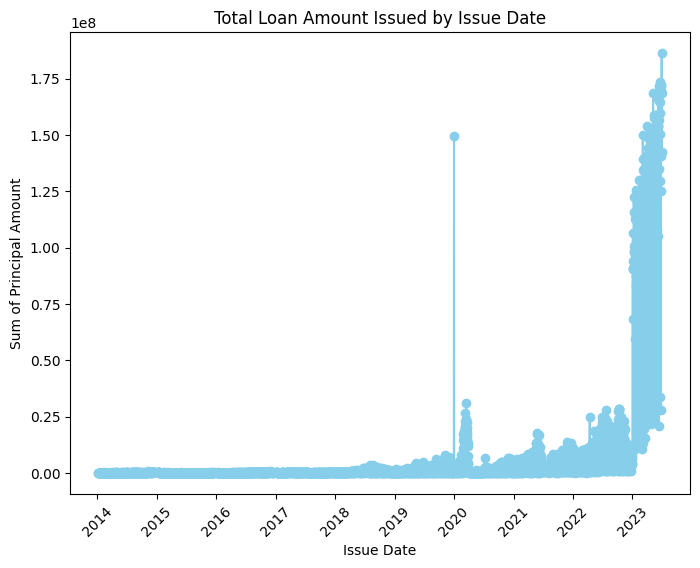

In [38]:
sum_by_issue_date = metrics_df.groupby('issue_date')['principal_amount'].sum()

plt.figure(figsize=(8, 6))
plt.plot(sum_by_issue_date.index, sum_by_issue_date.values, marker='o', color='skyblue')
plt.title('Total Loan Amount Issued by Issue Date')
plt.xlabel('Issue Date')
plt.ylabel('Sum of Principal Amount')

plt.xticks(rotation=45)
plt.show()

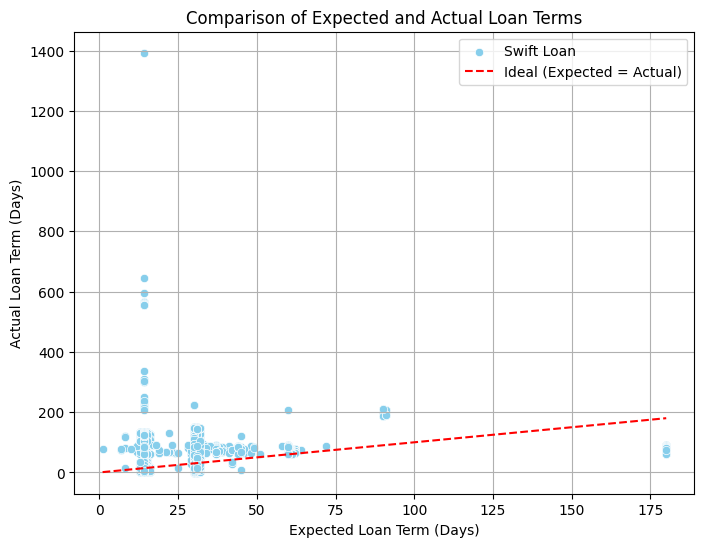

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=metrics_df['expected_term_days'], y=metrics_df['actual_term_days'], 
                label='Swift Loan', color='skyblue')

plt.plot([metrics_df['expected_term_days'].min(), metrics_df['expected_term_days'].max()],
         [metrics_df['expected_term_days'].min(), metrics_df['expected_term_days'].max()],
         linestyle='--', color='red', label='Ideal (Expected = Actual)')

plt.title('Comparison of Expected and Actual Loan Terms')
plt.xlabel('Expected Loan Term (Days)')
plt.ylabel('Actual Loan Term (Days)')

plt.legend()
plt.grid(True)
plt.show()

In [40]:
demographic_arrears = metrics_df.groupby(['gender', 'country'],observed=True).agg(
    avg_days_in_arrears=('days_in_arrears', 'mean'),
    write_off_rate=('write_off_amount_usd', lambda x: x.notnull().mean())
).reset_index()
demographic_arrears

,gender,country,avg_days_in_arrears,write_off_rate
0,Female,Kenya,21.47,0.36
1,Female,Uganda,29.93,0.41
2,Male,Kenya,21.43,0.34
3,Male,Uganda,28.77,0.40


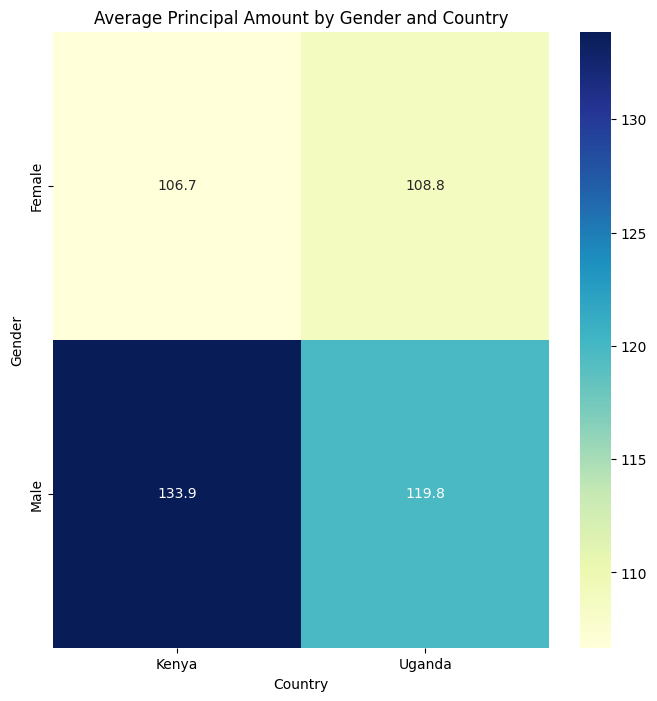

In [41]:
demographic_principal_amount = metrics_df.groupby(['gender', 'country'],observed=True)['principal_amount_usd'].mean().unstack()

plt.figure(figsize=(8, 8))
sns.heatmap(demographic_principal_amount, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Average Principal Amount by Gender and Country')
plt.xlabel('Country')
plt.ylabel('Gender')
plt.show()


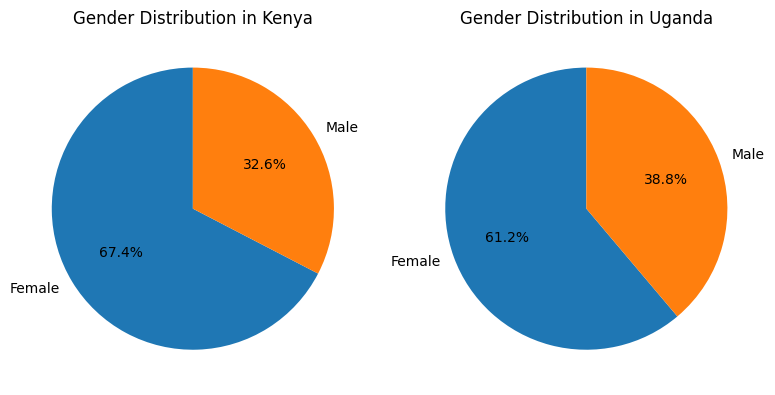

In [42]:
demographic_principal = metrics_df.groupby(['gender', 'country'], observed=True)['principal_amount_usd'].sum().unstack()
demographic_principal_percentage = demographic_principal.div(demographic_principal.sum(axis=0), axis=1) * 100

fig, axes = plt.subplots(nrows=1, ncols=demographic_principal_percentage.shape[1], figsize=(8, 8))

for i, country in enumerate(demographic_principal_percentage.columns):
    ax = axes[i]
    ax.pie(demographic_principal_percentage[country], labels=demographic_principal_percentage.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Gender Distribution in {country}')

plt.tight_layout()
plt.show()

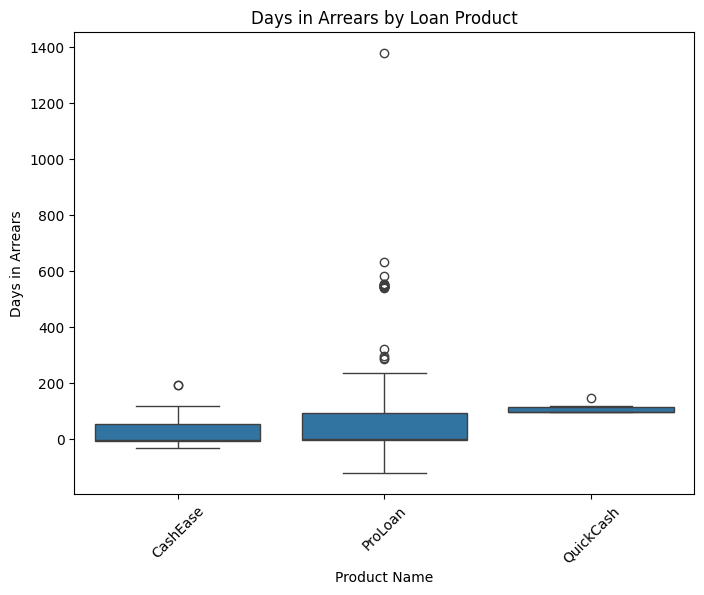

In [43]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=metrics_df, x='product_name', y='days_in_arrears')
plt.title('Days in Arrears by Loan Product')
plt.xlabel('Product Name')
plt.ylabel('Days in Arrears')
plt.xticks(rotation=45)
plt.show()
